In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score, roc_curve, RocCurveDisplay, plot_roc_curve
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [2]:
# load the dataset
df_jobs = pd.read_csv('datasets/fake_job_postings.csv')
df_jobs.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [3]:
df_jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [4]:
df_jobs['salary_range'].value_counts(normalize=True)

0-0            0.049512
40000-50000    0.023013
30000-40000    0.019177
25000-30000    0.012901
45000-67000    0.012901
                 ...   
15-25          0.000349
60-75          0.000349
27500-36000    0.000349
20-22          0.000349
3700-3800      0.000349
Name: salary_range, Length: 874, dtype: float64

In [32]:
df_jobs.query('fraudulent == 0')['benefits'].unique().tolist()

[nan,
 'What you will get from usThrough being part of the 90 Seconds team you will gain:experience working on projects located around the world with an international brandexperience working with a variety of clients and on a large range of projectsopportunity to drive and grow production function and teama positive working environment with a great teamPay$40,000-$55,000Applying for this role with a VIDEOBeing a video business, we understand that one of the quickest ways that we can assess your suitability for this role, and one of the quickest ways that you can apply for it, is for you to submit a 60-90 second long video telling us about yourself, your experience and why you think you would be perfect for the role. \xa0It’s not about being a filmmaker or making a really creative video. \xa0A simple video filmed with a smart phone or web cam will be fine. Please also include where you are based and when you can start.You can upload the video onto YouTube or Vimeo (or similar) as a Draf

<AxesSubplot:xlabel='telecommuting', ylabel='count'>

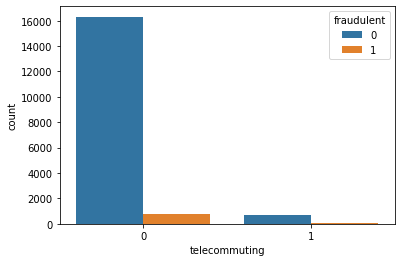

In [5]:
sns.countplot(x='telecommuting', hue='fraudulent', data=df_jobs)

In [6]:
# df_jobs[df_jobs['fraudulent'] == 1]['company_profile'].value_counts().index.tolist()

In [25]:
df_jobs[
    df_jobs['description'].isin(df_jobs[df_jobs['fraudulent'] == 1]['description'].value_counts().index.tolist())
]['fraudulent'].value_counts()

1    865
0      2
Name: fraudulent, dtype: int64

In [8]:
df_jobs[
    (df_jobs['description'].isin(df_jobs[df_jobs['fraudulent'] == 1]['description'].value_counts().index.tolist()))
    & (df_jobs['fraudulent'] == 0)
]

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
11889,11890,Developer (Front-end team),"GR, I, Athens",Engineering,NaN,Workable is a venture-backed startup making cl...,Workable is a product-driven software company....,"To be considered seriously, you will also have...",Our goal is to create a company where employee...,0,1,1,Full-time,Not Applicable,Bachelor's Degree,Computer Software,Engineering,0
15236,15237,Developer,"GR, I, Athens",Engineering,NaN,Workable is a venture-backed startup making cl...,Workable is a product-driven software company....,"To be considered seriously, you will also have...",Our goal is to create a company where employee...,0,1,1,Full-time,Not Applicable,Bachelor's Degree,Computer Software,Engineering,0


## Single Variable: Company Profile

In [40]:
# train test split
X = df_jobs[['company_profile']]
y = df_jobs['fraudulent'].values.reshape(-1, 1)

X.fillna(value='empty', inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=22)

/home/idrishaidar/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [41]:
# extract feature columns from company profile

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))
X_train_vectorized = tfidf_vectorizer.fit_transform(X_train['company_profile'])
X_test_vectorized = tfidf_vectorizer.transform(X_test['company_profile'])

oversampler = RandomOverSampler(random_state=22)
undersampler = RandomUnderSampler(random_state=22)
# X_train_ovr, y_train_ovr = oversampler.fit_resample(X_train_vectorized, y_train)
X_train_unr, y_train_unr = undersampler.fit_resample(X_train_vectorized, y_train)

In [34]:
tfidf_vectorizer.get_feature_names_out()

array(['000', '000 000', '000 active', ..., '你值得擁有的價格', 'ﬁnd', 'ﬁnd new'],
      dtype=object)

In [11]:
# model training

log_reg = LogisticRegression(random_state=22)
# log_reg.fit(X_train_vectorized, y_train.ravel())
# log_reg.fit(X_train_ovr, y_train_ovr)
log_reg.fit(X_train_unr, y_train_unr)

LogisticRegression(random_state=22)

In [12]:
# log_reg.score(X_train_vectorized, y_train)
# log_reg.score(X_train_ovr, y_train_ovr)
log_reg.score(X_train_unr, y_train_unr)

0.9011544011544012

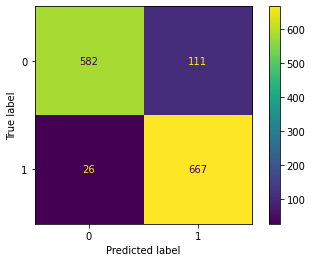

In [13]:
# plot_confusion_matrix(log_reg, X_train_vectorized, y_train)
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_train_unr, log_reg.predict(X_train_unr))
).plot()

/home/idrishaidar/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


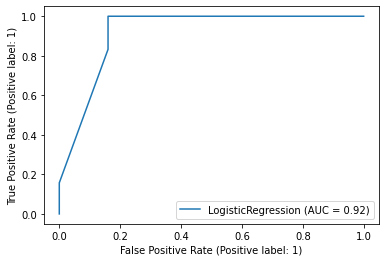

In [14]:
plot_roc_curve(log_reg, X_train_unr, y_train_unr)

In [15]:
precision_score(y_train_unr, log_reg.predict(X_train_unr))

0.8573264781491002

In [16]:
recall_score(y_train_unr, log_reg.predict(X_train_unr))

0.9624819624819625

In [17]:
log_reg.score(X_test_vectorized, y_test)

0.8400447427293065

In [18]:
precision_score(y_test, log_reg.predict(X_test_vectorized))

0.22558459422283356

In [19]:
recall_score(y_test, log_reg.predict(X_test_vectorized))

0.9479768786127167